In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
train = pd.read_csv('Data/capstone_train.csv')
test = pd.read_csv('Data/capstone_test.csv')
combined_data = pd.concat((train,test))
combined_data.head()
data_usl = pd.read_csv('Data/filled_data.csv').drop(['Interest_Rate'],axis = 1)

In [5]:
# combined_data['Number_Closed_Accounts'] = combined_data['Total_Accounts'] - combined_data['Number_Open_Accounts'] 

In [73]:
#Create bins for Months_Since_Deliquency as 0:No Deliquency,NaN: Unknown,

In [74]:
#Make Months_Since_Delinquency as Delinquent 

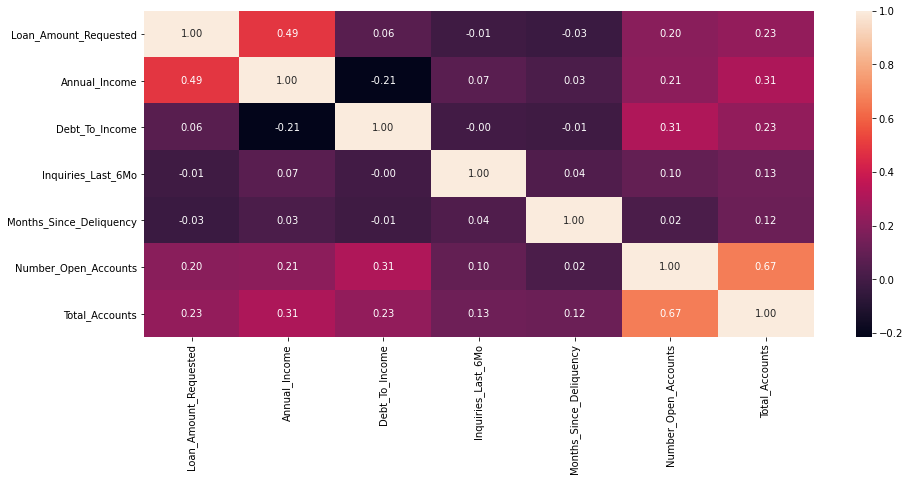

In [8]:
plt.figure(figsize = (15,6))
sns.heatmap(data_usl.corr(),annot = True,fmt = '.2f')
plt.show()

### Feature Engineering

In [9]:
# data_usl['Annual_Income:Loan_Amt'] = data_usl['Annual_Income']/data_usl['Loan_Amount_Requested']
# #Drop Annual_Income since the variable is highly correlated with multiple vars.
# data_usl.drop('Annual_Income',axis = 1,inplace = True)
# #Create a new column called closed accounts
# data_usl['Closed_accounts'] = data_usl['Total_Accounts']-data_usl['Number_Open_Accounts']
# #Create a new column called closed_acc:total_acc
# data_usl['Closed_acc:Total_acc'] = data_usl['Closed_accounts']/data_usl['Total_Accounts']
# #Drop Total_Accounts
# data_usl.drop('Total_Accounts',axis = 1,inplace = True)

In [75]:
#Covernt Length_Employed to Numerical
def emp_num(x):
    temp = x.split()
    for i in temp:
        if i == '<':
            return int(1)
        elif i == '10+':
            return int(10)
        else:
            return int(x.strip('years'))

In [76]:
data_usl['Length_Employed'] = data_usl['Length_Employed'].apply(emp_num)

In [77]:
#For USL I feel we can use LabelEncoder for all the columns since we need not have to worry much about magnitude.
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in data_usl.select_dtypes('object').columns:
    data_usl[i] = le.fit_transform(data_usl[i])

In [78]:
data_usl.sample(5)

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender
131354,25000.0,4,4,50000.0,0,2,27.0,0.0,0.0,7.0,21.0,0
232145,16000.0,3,0,68000.0,0,2,14.0,3.0,0.0,10.0,17.0,1
23988,9125.0,10,0,78000.0,1,2,10.0,0.0,16.0,9.0,31.0,1
56951,33000.0,10,4,111478.0,0,9,18.0,0.0,68.0,11.0,25.0,0
133360,20000.0,7,0,100000.0,0,1,14.0,0.0,0.0,15.0,33.0,1


# KMeans Clustering

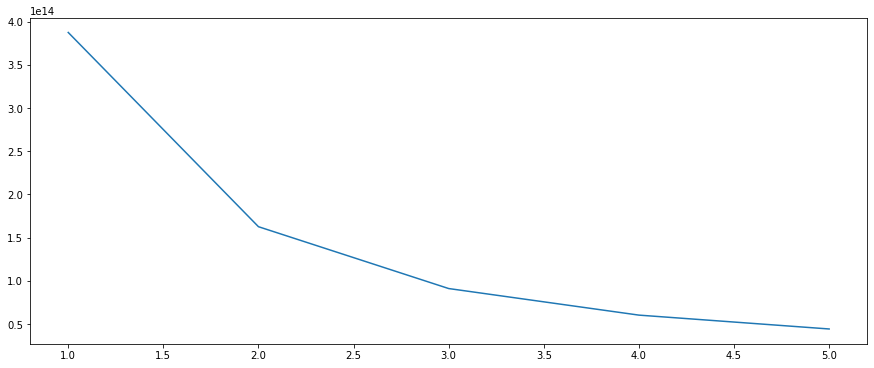

In [79]:
from sklearn.cluster import KMeans
wcv = []
for i in range(1,6):
    km = KMeans(n_clusters = i)
    km.fit(data_usl)
    wcv.append(km.inertia_)
    
#Plotting elbow
plt.figure(figsize = (15,6))
plt.plot(range(1,6),wcv)
plt.show()

#We can see both 2 and 3 as ideal number of clusters for this dataset. We will go with 3 clusters since that is
#what was taken in the orginal dataset.

# Hierarchial Clustering

In [16]:
from sklearn.cluster import AgglomerativeClustering

###### Building the dendrogram

In [26]:
#Standardizing data
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = pd.DataFrame(ss.fit_transform(data_usl),columns = data_usl.columns).sample(10000)

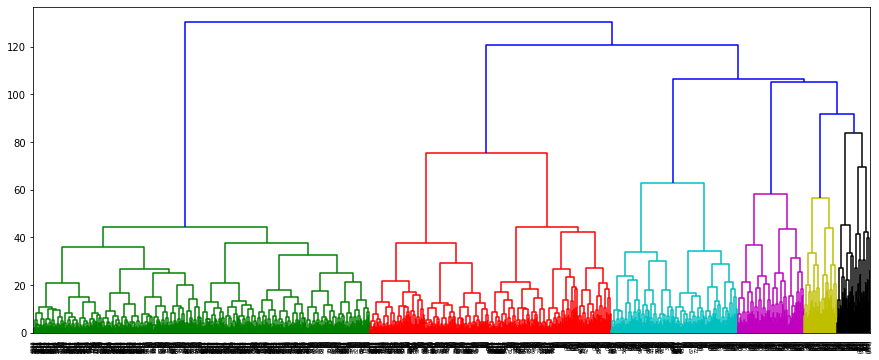

In [29]:
import scipy.cluster.hierarchy as sh
plt.figure(figsize = (15,6))
sh.dendrogram(sh.linkage(X,method = 'ward'),p = 10,truncate_mode = 'level')
plt.show()
#Gives memory error when using entire dataset.

In [30]:
#I can mainly see 2 clusters being formed here

# PCA

In [86]:
from sklearn.decomposition import PCA
import numpy as np
X = pd.DataFrame(ss.fit_transform(data_usl),columns = data_usl.columns)
pca = PCA()
pca.fit(X)
d = np.cumsum(pca.explained_variance_ratio_)
optimal_dimensions = np.argmax(d>0.95)+1
print(optimal_dimensions)#With 95% explained Variance

11


In [87]:
from sklearn.decomposition import PCA
pca = PCA(n_components = optimal_dimensions)
X_pca = pd.DataFrame(pca.fit_transform(X))

# DBSCAN (Density Based Spatial Clustering Applications with Noise)

In [35]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps = 0.3)
y_pred = dbscan.fit_predict(data_usl)

## Applying KMeans Clustering

In [89]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 2)
km.fit(X_pca)
target = km.predict(X_pca)

In [92]:
#We have got 2 classes but we don't know which is which. For this we will use the existing train data and create a boxplot with debt to income and check

C:\Users\tejas\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


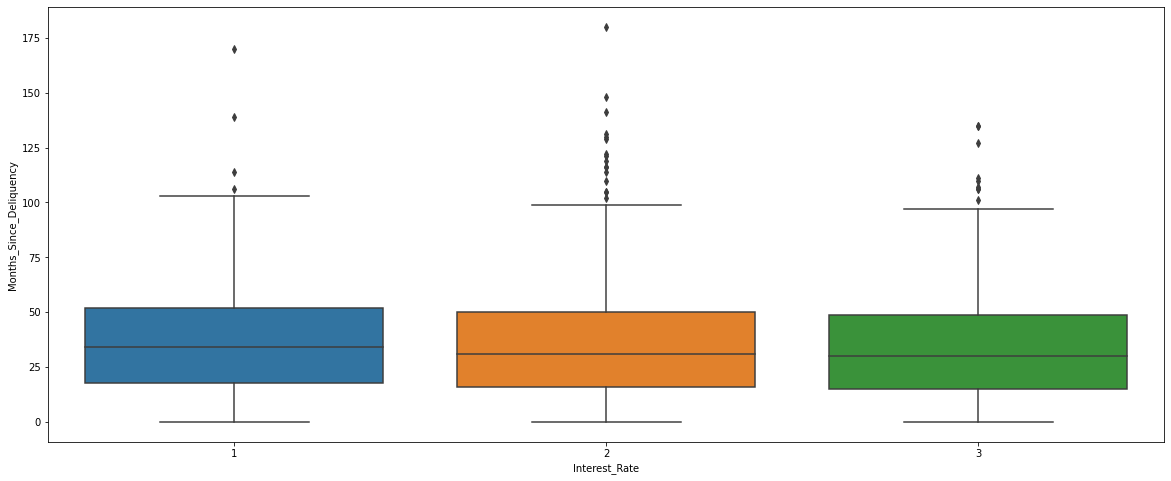

In [93]:
data_train = pd.read_csv('Data/capstone_train.csv')
plt.figure(figsize = (20,8))
sns.boxplot(data_train['Interest_Rate'],data_train['Months_Since_Deliquency'])
plt.show()

In [94]:
clusters_w_combined_data = pd.concat((data_usl,pd.Series(target,name = 'Interest_Rate')),axis = 1)

In [95]:
data_train['Interest_Rate'].value_counts()/len(data_train)

2    0.429557
3    0.364697
1    0.205746
Name: Interest_Rate, dtype: float64

In [96]:
clusters_w_combined_data['Interest_Rate'].value_counts()/len(clusters_w_combined_data)

0    0.546962
1    0.453038
Name: Interest_Rate, dtype: float64

In [97]:
data_train['Interest_Rate']

0         1
1         3
2         3
3         3
4         1
         ..
164304    2
164305    2
164306    1
164307    3
164308    2
Name: Interest_Rate, Length: 164309, dtype: int64

In [101]:
clusters_w_combined_data['Interest_Rate']

0         0
1         1
2         1
3         1
4         1
         ..
268619    1
268620    1
268621    0
268622    0
268623    0
Name: Interest_Rate, Length: 268624, dtype: int32

C:\Users\tejas\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


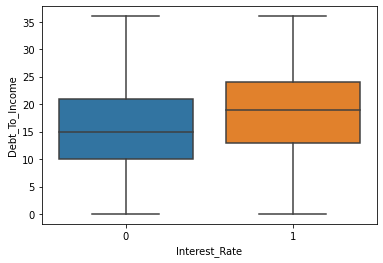

In [102]:
sns.boxplot(clusters_w_combined_data['Interest_Rate'],clusters_w_combined_data['Debt_To_Income'])
#1: High Risk
#2: Low Risk

C:\Users\tejas\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


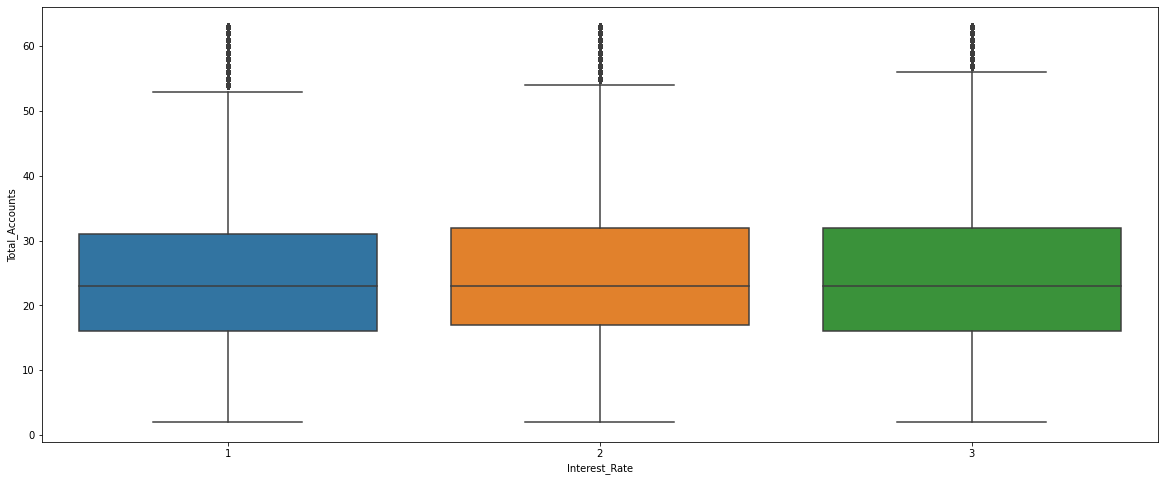

In [103]:
data_train = pd.read_csv('Data/capstone_train.csv')
plt.figure(figsize = (20,8))
sns.boxplot(data_train['Interest_Rate'],clusters_w_combined_data['Total_Accounts'])
plt.show()

In [104]:
data_train

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,"7,000",< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1
1,10000002,"30,000",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3
2,10000003,"24,725",7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3
3,10000004,"16,000",< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,3
4,10000005,"17,000",8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164304,10164305,"20,725",10+ years,Rent,NaN,VERIFIED - income source,credit_card,13.56,0,NaN,13,16,Male,2
164305,10164306,"6,000",8 years,Own,NaN,VERIFIED - income source,small_business,9.12,0,36.0,13,30,Male,2
164306,10164307,"20,250",10+ years,Mortgage,NaN,VERIFIED - income,credit_card,18.17,1,NaN,17,30,Male,1
164307,10164308,"10,000",4 years,Rent,NaN,not verified,major_purchase,18.75,1,48.0,16,62,Female,3


In [105]:
def Interst_conv(x):
    if x==1:
        return 'High'
    elif x==0:
        return 'low'
clusters_w_combined_data['Interest_Rate'] = clusters_w_combined_data['Interest_Rate'].apply(Interst_conv)

In [107]:
clusters_w_combined_data.to_csv('Data/2_Category.csv',index = False)

C:\Users\tejas\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


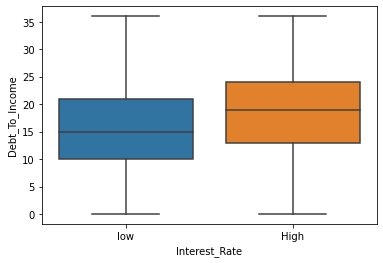

In [108]:
sns.boxplot(clusters_w_combined_data['Interest_Rate'],clusters_w_combined_data['Debt_To_Income'])